# In this notebook

training data is generated from the combinations of different description embeddings.

Loss function only considers positive pairs (All the other pairs will be considers as negative ones).

Loss function from tutorial: [tutorial](https://github.com/dhruvbird/ml-notebooks/blob/main/nt-xent-loss/NT-Xent%20Loss.ipynb), which is based on binary cross entropy loss

In [1]:
import pandas as pd
import numpy as np
import json

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import sys
import os
sys.path.append(os.path.abspath('../'))
from tool import *

import matplotlib.pyplot as plt


data_root = '../../MyData/'

# New load data

In [2]:
train_data = torch.load("../5_synthetic_data_generation/data/train_data.pth")
train_label = torch.load("../5_synthetic_data_generation/data/train_label.pth")
test_data = torch.load("../5_synthetic_data_generation/data/test_data.pth")
test_label = torch.arange(1197)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

torch.Size([34683, 256])
torch.Size([34683])
torch.Size([1197, 256])
torch.Size([1197])


In [6]:
# Get cik
exp_df = pd.read_csv("./data/embedding_256.csv")[['cik', 'tic', 'Year']]
print(len(exp_df))

unique_cik = exp_df['cik'].unique()
cik_to_index = {cik: idx for idx, cik in enumerate(unique_cik)}
index_to_cik = {idx: cik for idx, cik in enumerate(unique_cik)}
print("CIK to Index Mapping:", cik_to_index)

1197
CIK to Index Mapping: {850460: 0, 352541: 1, 1704715: 2, 1575515: 3, 1125376: 4, 1674335: 5, 1023128: 6, 1262039: 7, 1122976: 8, 1128928: 9, 58492: 10, 40533: 11, 1370946: 12, 1469367: 13, 858655: 14, 1486159: 15, 70145: 16, 77476: 17, 1593034: 18, 1140536: 19, 1353283: 20, 912728: 21, 73309: 22, 1754301: 23, 882796: 24, 1309402: 25, 1524358: 26, 80424: 27, 1551182: 28, 1283699: 29, 1158172: 30, 8947: 31, 804328: 32, 1120370: 33, 1655075: 34, 1361658: 35, 40987: 36, 1320414: 37, 1584509: 38, 1466301: 39, 1552033: 40, 1281761: 41, 93410: 42, 76282: 43, 19584: 44, 723531: 45, 1530804: 46, 101984: 47, 910329: 48, 5513: 49, 31462: 50, 1338749: 51, 1409171: 52, 821026: 53, 817720: 54, 5272: 55, 1013871: 56, 1111928: 57, 1393818: 58, 66382: 59, 812011: 60, 730708: 61, 1672013: 62, 1109242: 63, 883945: 64, 1527166: 65, 1421461: 66, 355811: 67, 1262823: 68, 26058: 69, 14930: 70, 1637459: 71, 892553: 72, 1345016: 73, 844965: 74, 1318220: 75, 819793: 76, 1175454: 77, 936468: 78, 29989: 79, 

In [4]:
dissimilar_df = pd.read_csv(data_root + "dissimilar_pairs_2021.csv")
print(f"length of dissimilar_df: {len(dissimilar_df)}")
print(f"dissimilar_df columns: {dissimilar_df.columns}")
company_a_cik_set = set(dissimilar_df['company_a_cik'].unique())
company_b_cik_set = set(dissimilar_df['company_b_cik'].unique())
dissimilar_union_set = company_a_cik_set.union(company_b_cik_set)
print(f"number of firms occured in dissimilar_df: {len(dissimilar_union_set)} \n")

similar_df = pd.read_csv(data_root + "pairs_gpt_competitors_2021.csv")
print(f"length of similar_df: {len(similar_df)}")
print(f"similar_df columns: {similar_df.columns}")
company_a_cik_set = set(similar_df['company_a_cik'].unique())
company_b_cik_set = set(similar_df['company_b_cik'].unique())
similar_union_set = company_a_cik_set.union(company_b_cik_set)
print(f"number of firms occured in similar_df: {len(similar_union_set)} \n")

print(f"final union set length: {len(dissimilar_union_set.union(similar_union_set))}")

# similar_df = similar_df[['company_a_cik', 'company_b_cik']]
# dissimilar_df = dissimilar_df[['company_a_cik', 'company_b_cik']]

length of dissimilar_df: 2913
dissimilar_df columns: Index(['Unnamed: 0', 'company_a_name', 'company_a_cik', 'company_a_products',
       'company_b_cik', 'company_b_name', 'company_b_tic',
       'company_b_products', 'reason_for_dissimilarity'],
      dtype='object')
number of firms occured in dissimilar_df: 1196 

length of similar_df: 2365
similar_df columns: Index(['Unnamed: 0', 'company_a_name', 'company_a_cik', 'company_b_cik',
       'company_b_name', 'company_b_tic', 'competing_products'],
      dtype='object')
number of firms occured in similar_df: 1110 

final union set length: 1197


# Create dataset

### Prepare labels

In [7]:
# Get number of unique entities
N = len(unique_cik)

# Initialize the relation matrix with -1 (unknown/no relation)
relation_matrix = -1 * np.ones((N, N))

# Fill in similar pairs
for _, row in similar_df.iterrows():
    i, j = cik_to_index[row['company_a_cik']], cik_to_index[row['company_b_cik']]
    relation_matrix[i, j] = 1
    relation_matrix[j, i] = 1  # Ensure symmetry

# Fill in dissimilar pairs
for _, row in dissimilar_df.iterrows():
    i, j = cik_to_index[row['company_a_cik']], cik_to_index[row['company_b_cik']]
    relation_matrix[i, j] = 0
    relation_matrix[j, i] = 0  # Ensure symmetry

# Set diagonal to -1 (self-relations not needed)
np.fill_diagonal(relation_matrix, -1)

# Convert to PyTorch tensor
relation_matrix = torch.tensor(relation_matrix, dtype=torch.float32)

print("Relation Matrix:\n", relation_matrix)


# Count number of 1's
num_ones = (relation_matrix == 1).sum().item()

# Count number of -1's
num_neg_ones = (relation_matrix == 0).sum().item()

print(f"Number of 1's: {num_ones}")
print(f"Number of 0's: {num_neg_ones}")

Relation Matrix:
 tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])
Number of 1's: 4564
Number of 0's: 5826


#### **Some similar pairs are useless!**

In [6]:
# print(len(similar_df))
# print(len(dissimilar_df))
# similar_df[similar_df['company_a_cik'] == similar_df['company_b_cik']]

### Final step

In [8]:
# Define a custom dataset
class ContrastiveDataset(Dataset):
    def __init__(self, data, index_list):
        self.data = data
        self.index_list = index_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.index_list[idx]



train_dataset = ContrastiveDataset(train_data, train_label)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = ContrastiveDataset(test_data, torch.arange(1197))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Model training

In [9]:
class ProjectionNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(ProjectionNet, self).__init__()
        
        # Define the layers sequentially
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),         # First fully connected layer
            nn.BatchNorm1d(hidden_dim),               # Batch Normalization
            nn.LeakyReLU(negative_slope=0.01),        # LeakyReLU activation
            # nn.Dropout(p=dropout_prob),               # Dropout
            nn.Linear(hidden_dim, output_dim)         # Second fully connected layer
        )
    
    def forward(self, x):
        # Pass the input through the sequential model
        return self.model(x)

#### Train with contrastive loss 2

In [13]:
def nt_bxent_loss(x, pos_indices, temperature):
    assert len(x.size()) == 2

    # Add indexes of the principal diagonal elements to pos_indices
    pos_indices = torch.cat([
        pos_indices,
        torch.arange(x.size(0)).reshape(x.size(0), 1).expand(-1, 2),
    ], dim=0)
    
    # Ground truth labels
    target = torch.zeros(x.size(0), x.size(0))
    target[pos_indices[:,0], pos_indices[:,1]] = 1.0

    # Cosine similarity
    xcs = F.cosine_similarity(x[None,:,:], x[:,None,:], dim=-1)
    # Set logit of diagonal element to "inf" signifying complete
    # correlation. sigmoid(inf) = 1.0 so this will work out nicely
    # when computing the Binary Cross Entropy Loss.
    xcs[torch.eye(x.size(0)).bool()] = float("inf")

    # Standard binary cross entropy loss. We use binary_cross_entropy() here and not
    # binary_cross_entropy_with_logits() because of https://github.com/pytorch/pytorch/issues/102894
    # The method *_with_logits() uses the log-sum-exp-trick, which causes inf and -inf values
    # to result in a NaN result.
    loss = F.binary_cross_entropy((xcs / temperature).sigmoid(), target, reduction="none")
    
    target_pos = target.bool()
    target_neg = ~target_pos
    
    loss_pos = torch.zeros(x.size(0), x.size(0)).masked_scatter(target_pos, loss[target_pos])
    loss_neg = torch.zeros(x.size(0), x.size(0)).masked_scatter(target_neg, loss[target_neg])
    loss_pos = loss_pos.sum(dim=1)
    loss_neg = loss_neg.sum(dim=1)
    num_pos = target.sum(dim=1)
    num_neg = x.size(0) - num_pos

    return ((loss_pos / num_pos) + (loss_neg / num_neg)).mean()

#### Might be useless

In [ ]:
# def contrastive_loss(batch_output, pos_pairs, temperature=0.5):
#     """
#     Computes the contrastive loss using NT-Xent (Normalized Temperature-scaled Cross Entropy Loss).
    
#     Args:
#         batch_output (torch.Tensor): Tensor of shape (B, D) containing the model outputs.
#         pos_pairs (List[Tuple[int, int]]): List of positive index pairs.
#         neg_pairs (List[Tuple[int, int]]): List of negative index pairs.
#         temperature (float): Scaling factor for the similarity scores.

#     Returns:
#         loss (torch.Tensor): Contrastive loss.
#     """
#     # Compute similarity matrix (cosine similarity)
#     batch_output = F.normalize(batch_output, dim=1)  # Normalize embeddings
#     sim_matrix = torch.mm(batch_output, batch_output.T)  # (B, B) similarity matrix
#     sim_matrix /= temperature

#     loss = 0
#     num_pairs = 0

#     # Compute loss for positive pairs
#     for i, j in pos_pairs:
#         num_pairs += 1
#         sim_ij = sim_matrix[i, j]
#         exp_sim_ij = torch.exp(sim_ij)

#         # Negative samples
#         neg_sims = sim_matrix[i, :]
#         exp_neg_sims = torch.exp(neg_sims)
#         exp_neg_sims[j] = 0  # Exclude the positive pair itself

#         loss += -torch.log(exp_sim_ij / (torch.sum(exp_neg_sims) + exp_sim_ij))  # NT-Xent formula

#     return loss / num_pairs if num_pairs > 0 else torch.tensor(0.0, device=batch_output.device)




# # def ContrastiveLoss2(batch_output, pos_pairs, neg_pairs, temperature=0.5):
# #     """
# #     Computes the contrastive loss using NT-Xent (Normalized Temperature-scaled Cross Entropy Loss).
    
# #     Args:
# #         batch_output (torch.Tensor): Tensor of shape (B, D) containing the model outputs.
# #         pos_pairs (List[Tuple[int, int]]): List of positive index pairs.
# #         neg_pairs (List[Tuple[int, int]]): List of negative index pairs.
# #         temperature (float): Scaling factor for the similarity scores.

# #     Returns:
# #         loss (torch.Tensor): Contrastive loss.
# #     """
# #     # Normalize embeddings to ensure cosine similarity is in [-1,1]
# #     batch_output = F.normalize(batch_output, dim=1)
    
# #     # Compute cosine similarity matrix
# #     sim_matrix = torch.mm(batch_output, batch_output.T)  # (B, B) similarity matrix
    
# #     loss = 0
# #     num_pairs = 0

# #     # Compute loss for positive pairs
# #     for i, j in pos_pairs:
# #         num_pairs += 1
# #         sim_ij = sim_matrix[i, j] / temperature  # Scaled similarity
# #         exp_sim_ij = torch.exp(sim_ij)

# #         # Negative samples: Use all negative pairs plus all non-positive pairs
# #         neg_sims = torch.exp(sim_matrix[i, :] / temperature)  # All similarities for anchor i
# #         neg_sims[j] = 0  # Exclude the positive pair itself

# #         # Explicitly include negative pairs
# #         for neg_i, neg_j in neg_pairs:
# #             neg_sims[neg_j] = torch.exp(sim_matrix[neg_i, neg_j] / temperature)

# #         loss += -torch.log(exp_sim_ij / (torch.sum(neg_sims) + exp_sim_ij))  # NT-Xent formula

# #     return loss / num_pairs if num_pairs > 0 else torch.tensor(0.0, device=batch_output.device)


#### Make full use of the sample in each batch

In [ ]:
import itertools

def get_positive_negative_pairs(batch_indices):
    # Extract the batch submatrix
    batch_rel_matrix = relation_matrix[batch_indices][:, batch_indices]  # Shape (B, B)

    # Find indices where the relation value is 1
    pos_pairs = torch.nonzero(batch_rel_matrix == 1, as_tuple=False)  # Shape (N, 2)

    return pos_pairs

In [30]:
input_dim = 256
output_dim = 128
hidden_dim = 256
temperature = 0.5


model = ProjectionNet(input_dim, output_dim, hidden_dim)
criterion = nt_bxent_loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch_data, batch_idx in train_loader:

        batch_size = batch_data.size(0)

        z1 = model(batch_data)
        pos_pairs = get_positive_negative_pairs(batch_idx)

        loss = torch.tensor(0.0, device=z1.device, requires_grad=True)
        if len(pos_pairs) > 0:
            loss = loss + criterion(z1, pos_pairs, temperature)
        # if len(neg_pairs) > 0:
        #     loss = loss + criterion(neg_pairs, torch.zeros(len(neg_pairs)))

        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], train_avg_Loss: {total_loss/len(train_loader):.4f}")

    total_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_data, batch_idx in test_loader:

            batch_size = batch_data.size(0)

            z1 = model(batch_data)
            pos_pairs = get_positive_negative_pairs(batch_idx)

            loss = torch.tensor(0.0, device=z1.device, requires_grad=True)
            if len(pos_pairs) > 0:  # Check if there's at least one valid pair
                # Compute loss
                loss = loss + criterion(z1, pos_pairs, temperature)
            # if len(neg_pairs) > 0:
            #     loss = loss + criterion(neg_pairs, torch.zeros(len(neg_pairs)))
            
            total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], test_avg_Loss: {total_loss/len(test_loader):.4f}\n")

Epoch [1/20], train_avg_Loss: 0.5504
Epoch [1/20], test_avg_Loss: 0.5719

Epoch [2/20], train_avg_Loss: 0.5313
Epoch [2/20], test_avg_Loss: 0.5117

Epoch [3/20], train_avg_Loss: 0.5444
Epoch [3/20], test_avg_Loss: 0.6064

Epoch [4/20], train_avg_Loss: 0.5476
Epoch [4/20], test_avg_Loss: 0.4540

Epoch [5/20], train_avg_Loss: 0.5288
Epoch [5/20], test_avg_Loss: 0.5094



KeyboardInterrupt: 

#### Clustering

In [31]:
model.eval()
with torch.no_grad():
    final_representation = model(test_data)
final_representation.shape

torch.Size([1197, 128])

In [32]:
exp_df['cluster_10'] = cluster(final_representation, 10)
exp_df['cluster_100'] = cluster(final_representation, 100)
exp_df

Normalized Within-Cluster Sum of Squares (WCSS): 0.11152251202958569
Normalized Within-Cluster Sum of Squares (WCSS): 0.05472320582135678


,cik,tic,Year,cluster_10,cluster_100
0,850460,WIRE,2021,8,54
1,352541,LNT,2021,7,8
2,1704715,AMR,2021,5,50
3,1575515,SFM,2021,0,4
4,1125376,ENSG,2021,1,80
...,...,...,...,...,...
1192,1021860,NOV,2021,9,73
1193,1744489,DIS,2021,8,40
1194,1102112,PACW,2021,2,99
1195,28823,DBD,2021,8,55


In [33]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp_returns = pd.merge(exp_df, returns_long, on='tic', how='inner')

exp_intra_corrs_10 = intra_industry_correlations(exp_returns, "cluster_10")
exp_avg_intra_corr_10 = np.nanmean(list(exp_intra_corrs_10.values()))
print(exp_avg_intra_corr_10)

exp_intra_corrs_100 = intra_industry_correlations(exp_returns, "cluster_100")
exp_avg_intra_corr_100 = np.nanmean(list(exp_intra_corrs_100.values()))
print(exp_avg_intra_corr_100)

print(len(exp_returns['cik'].unique()))

0.40571371514424187
0.44786511057935546
1064


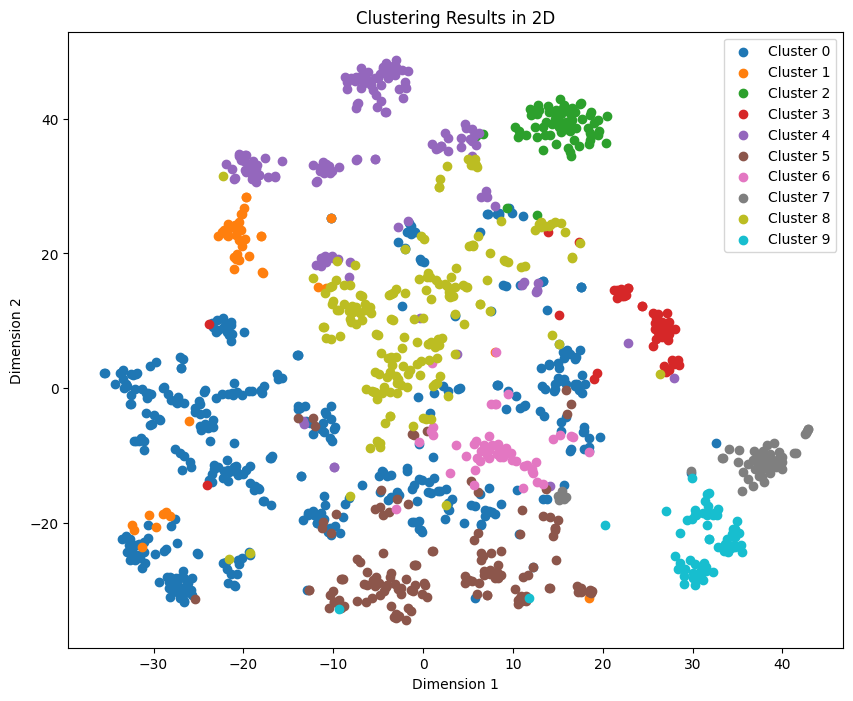

In [34]:
show_cluster_graph(final_representation, exp_df['cluster_10'])

# Pair eval

In [35]:
similar_df = pd.read_csv(data_root + "pairs_gpt_competitors_2021.csv")
similar_df = similar_df[similar_df['company_a_cik'] != similar_df['company_b_cik']]


In [36]:
similar_df_results = precision_and_false_positive(similar_df, exp_df.copy(), ['cluster_10', 'cluster_100'], 10000)
similar_df_results

Missing CIKs in pairs dataset: 0 (company A), 0 (company B)
CIKs not found in main dataset: 0 (company A), 0 (company B)
Total valid pairs: 2282
cluster_10
Original number of positive pairs: 2282
Number of positive pairs after filtering: 2282


cluster_100
Original number of positive pairs: 2282
Number of positive pairs after filtering: 2282




,Classification_Scheme,Precision,False_Positive_rate,N_Industries,Avg_Firms_per_Industry
0,cluster_10,0.848379,0.984823,10,119.70
1,cluster_100,0.689308,0.808637,100,11.97
